In [ ]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, Bidirectional, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
import json
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
json_file_path = "/content/drive/MyDrive/newsHeadlinesDataset.json"

In [ ]:
headlines = []
labels = []

with open(json_file_path, 'r') as f:
    for line in f:
        data = json.loads(line)
        headlines.append(data['headline'])
        labels.append(data['is_sarcastic'])

df = pd.DataFrame({
    'headline': headlines,
    'is_sarcastic': labels
})

print(df.head())

                                            headline  is_sarcastic
0  thirtysomething scientists unveil doomsday clo...             1
1  dem rep. totally nails why congress is falling...             0
2  eat your veggies: 9 deliciously different recipes             0
3  inclement weather prevents liar from getting t...             1
4  mother comes pretty close to using word 'strea...             1


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
df['headline'] = df['headline'].apply(preprocess_text)
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails congress falling short g...,0
2,eat veggies 9 deliciously different recipes,0
3,inclement weather prevents liar getting work,1
4,mother comes pretty close using word streaming...,1


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)
print(f'Training set shape: {train_df.shape}')
print(f'Test set shape: {test_df.shape}')
print(f'Validation set shape: {val_df.shape}')

Training set shape: (20605, 2)
Test set shape: (5724, 2)
Validation set shape: (2290, 2)


In [ ]:
train_embeddings_np = np.load('/content/drive/MyDrive/train_embeddings_np.npy')
val_embeddings_np = np.load('/content/drive/MyDrive/val_embeddings_np.npy')
test_embeddings_np = np.load('/content/drive/MyDrive/test_embeddings_np.npy')
train_labels_np = np.load('/content/drive/MyDrive/train_labels_np.npy')
test_labels_np = np.load('/content/drive/MyDrive/test_labels_np.npy')
val_labels_np = np.load('/content/drive/MyDrive/val_labels_np.npy')

In [ ]:
print("Train labels type:", type(train_labels_np))
print("Test labels type:", type(test_labels_np))
print("Val labels type:", type(val_labels_np))
print("Train embeddings shape:", train_embeddings_np.shape)
print("Test embeddings shape:", test_embeddings_np.shape)
print("Val embeddings shape:", val_embeddings_np.shape)

Train labels type: <class 'numpy.ndarray'>
Test labels type: <class 'numpy.ndarray'>
Val labels type: <class 'numpy.ndarray'>
Train embeddings shape: (20605, 768)
Test embeddings shape: (5724, 768)
Val embeddings shape: (2290, 768)


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def build_dense_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    activation='relu', input_shape=(train_embeddings_np.shape[1],)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
class MyTuner(kt.Hyperband):
    def run_trial(self, trial, *args, **kwargs):
        hp = trial.hyperparameters
        kwargs['batch_size'] = hp.Int('batch_size', min_value=32, max_value=96, step=32)
        return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
# densetuner = MyTuner(
#     build_dense_model,
#     objective='val_accuracy',
#     max_epochs=12,
#     factor=3,
#     directory='my_dir',
#     project_name='hyperparameter_tuning'
# )

# densetuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_dense_model = densetuner.get_best_models(num_models=1)[0]


# print(best_dense_model.summary())
# best_hps = densetuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"Optimal number of units in the first dense layer: {best_hps.get('units')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
# print(f"Optimal batch size: {best_hps.get('batch_size')}")

In [ ]:
# best_dense_model = Sequential([
#     Dense(96, activation='relu', input_shape=(train_embeddings_np.shape[1],)),
#     Dropout(0.1),
#     Dense(1, activation='sigmoid')
# ])
# best_dense_model.compile(optimizer=Adam(learning_rate=1e-3),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# print(best_dense_model.summary())

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_dense_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# history = best_dense_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np),
#                     callbacks = [checkpoint])

In [ ]:
best_dense_model = load_model('/content/drive/MyDrive/best_dense_model.h5')
best_dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 96)                73824     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 97        
                                                                 
Total params: 73921 (288.75 KB)
Trainable params: 73921 (288.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def getConfusionMatrix(model, test_embeddings_np, test_labels_np):
    test_predictions = model.predict(test_embeddings_np)
    test_predictions = (test_predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
    test_labels_np_flat = test_labels_np.flatten()
    cm = confusion_matrix(test_labels_np_flat, test_predictions)
    print("Confusion Matrix:")
    print(cm)
    return cm

In [ ]:
def metricsBarChart(accuracy, precision, anp, recall, tnp, f1):
    categories = ['Accuracy', 'Precision', 'ANP', 'Recall', 'TNP', 'F1']
    values = [accuracy, precision, anp, recall, tnp, f1]
    colors = ['#FF0000', '#0000FF', '#00FF00', '#FFFF00', '#FFC0CB', '#A52A2A']  # Shades of red for false, shades of green for true

    # Create the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, values, color=colors)

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

    # Title and labels
    plt.title('Classification Metrics')
    plt.ylabel('Percentage')
    plt.ylim(0, 100)

    # Show the plot
    plt.show()

In [ ]:
# def ConfusionMetricsElementsChart(tp, fp, tn, fn):
#     categories = ['True Positives %', 'False Positives %', 'True Negatives %', 'False Negatives %']
#     values = [tp, fp, tn, fn]
#     colors = ['#00FF00', '#FF0000', '#32CD32', '#8B0000']  # Shades of red for false, shades of green for true

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     bars = plt.bar(categories, values, color=colors)

#     # Add value labels on top of the bars
#     for bar in bars:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom')

#     # Title and labels
#     plt.title('Classification Metrics')
#     plt.ylabel('Percentage')
#     plt.ylim(0, 100)

#     # Show the plot
#     plt.show()

In [ ]:
def printAndDrawAdditionalMetrics(cm):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print the results
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1_score:.2f}")

    # Actual positive predicted as percentage of predicted positives
    precision = (TP / (FP + TP)) * 100
    # Actual negatives predicted as percentage of predicted negatives
    anp = (TN / (TN + FN)) * 100
    # True Positives as percentage of actual true labels
    recall = (TP / (TP + FN)) * 100
    # True Negatives as percentage of actual false labels
    tnp = (TN / (TN + FP)) * 100

    # Print the results
    print(f"Actual negatives predicted as percentage of predicted negatives: {anp:.2f}%")
    print(f"True Negatives as percentage of actual false labels: {tnp:.2f}%")

    metricsBarChart(accuracy*100, precision, anp, recall, tnp, f1_score*100)

179/179 [==============================] - 1s 3ms/step
Confusion Matrix:
[[2338  657]
 [ 455 2274]]
Accuracy: 0.81
Precision: 0.78
Recall: 0.83
F1 Score: 0.80
Actual negatives predicted as percentage of predicted negatives: 83.71%
True Negatives as percentage of actual false labels: 78.06%


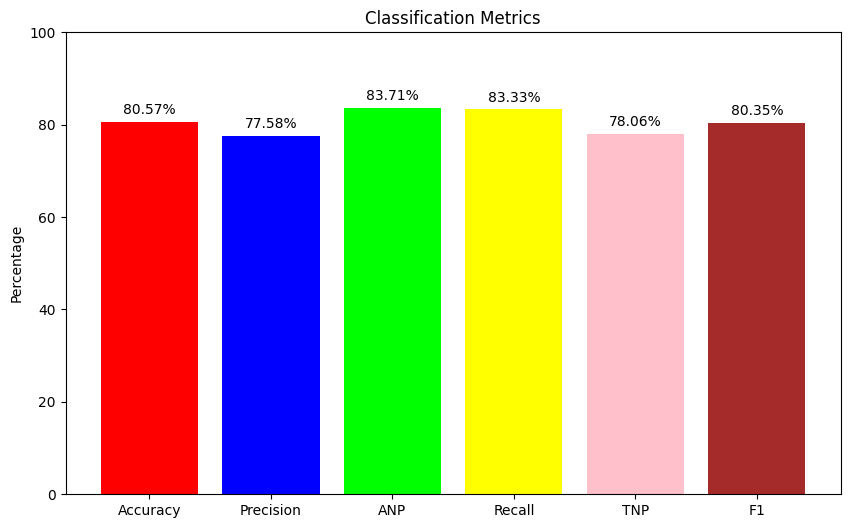

In [ ]:
dense_cm = getConfusionMatrix(best_dense_model, test_embeddings_np, test_labels_np)
printAndDrawAdditionalMetrics(dense_cm)

In [ ]:
# gru_model = Sequential([
#     GRU(224, input_shape=(train_embeddings_np.shape[1], 1), return_sequences=False),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# gru_model.compile(optimizer=Adam(learning_rate=1e-4),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

# # Summary of the model
# gru_model.summary()

In [ ]:
# history = gru_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np))

In [ ]:
# !pip install keras-tuner

In [ ]:
# import keras_tuner as kt

In [ ]:
def build_gru_model(hp):
    model = Sequential()
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    input_shape=(train_embeddings_np.shape[1],1), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# gru_tuner = MyTuner(
#     build_gru_model,
#     objective='val_accuracy',
#     max_epochs=12,
#     factor=3,
#     directory='my_dir_gru',
#     project_name='hyperparameter_tuning'
# )

# gru_tuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_gru_model = gru_tuner.get_best_models(num_models=1)[0]


# print(best_gru_model.summary())
# best_hps = gru_tuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"Optimal number of units in the first dense layer: {best_hps.get('units')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
# print(f"Optimal batch size: {best_hps.get('batch_size')}")

In [ ]:
# best_gru_model = Sequential([
#     GRU(96, input_shape=(train_embeddings_np.shape[1], 1), return_sequences=False),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# best_gru_model.compile(optimizer=Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_gru_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# # Summary of the model
# print(best_gru_model.summary())

# history = best_gru_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np),
#                     callbacks = [checkpoint])


In [ ]:
best_gru_model = load_model('/content/drive/MyDrive/best_gru_model.h5')
best_gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 96)                28512     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 28609 (111.75 KB)
Trainable params: 28609 (111.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# def plot_history(history):

#     train_acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']

#     # Generate a range of epochs
#     epochs = range(1, len(train_acc) + 1)

#     # Plot the training and validation accuracy
#     plt.figure(figsize=(10, 6))
#     plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
#     plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
#     plt.title('Training and Validation Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend()
#     plt.show()

In [ ]:
# plot_history(history)

179/179 [==============================] - 42s 231ms/step
Confusion Matrix:
[[2075  920]
 [1256 1473]]
Accuracy: 0.62
Precision: 0.62
Recall: 0.54
F1 Score: 0.58
Actual negatives predicted as percentage of predicted negatives: 62.29%
True Negatives as percentage of actual false labels: 69.28%


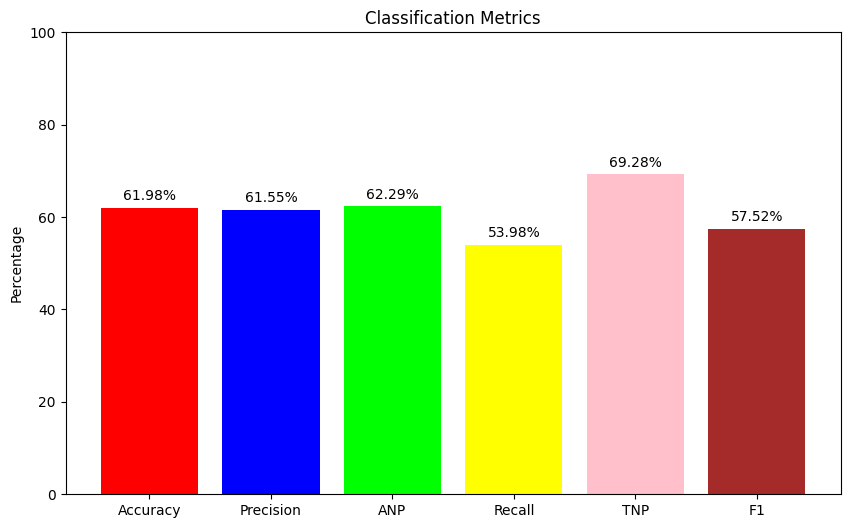

In [ ]:
gru_cm = getConfusionMatrix(best_gru_model, test_embeddings_np, test_labels_np)
printAndDrawAdditionalMetrics(gru_cm)

In [ ]:
def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                    input_shape=(train_embeddings_np.shape[1],1), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# lstm_tuner = MyTuner(
#     build_lstm_model,
#     objective='val_accuracy',
#     max_epochs=12,
#     factor=3,
#     directory='my_dir_lstm_1',
#     project_name='hyperparameter_tuning'
# )

# lstm_tuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_lstm_model = lstm_tuner.get_best_models(num_models=1)[0]


# print(best_lstm_model.summary())
# best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]


# print(f"Optimal number of units in the first dense layer: {best_hps.get('units')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
# print(f"Optimal batch size: {best_hps.get('batch_size')}")

In [ ]:
# lstm_best_model = Sequential([
#     LSTM(96, input_shape=(train_embeddings_np.shape[1], 1), return_sequences=False),
#     Dropout(0.4),
#     Dense(1, activation='sigmoid')
# ])


# lstm_best_model.compile(optimizer=Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


# print(lstm_best_model.summary())

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# history = lstm_best_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=96,
#                     validation_data=(val_embeddings_np, val_labels_np),
#                     callbacks=[checkpoint])

In [ ]:
best_lstm_model = load_model('/content/drive/MyDrive/best_lstm_model.h5')
best_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 96)                37632     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 97        
                                                                 
Total params: 37729 (147.38 KB)
Trainable params: 37729 (147.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


179/179 [==============================] - 31s 166ms/step
Confusion Matrix:
[[1908 1087]
 [1081 1648]]
Accuracy: 0.62
Precision: 0.60
Recall: 0.60
F1 Score: 0.60
Actual negatives predicted as percentage of predicted negatives: 63.83%
True Negatives as percentage of actual false labels: 63.71%


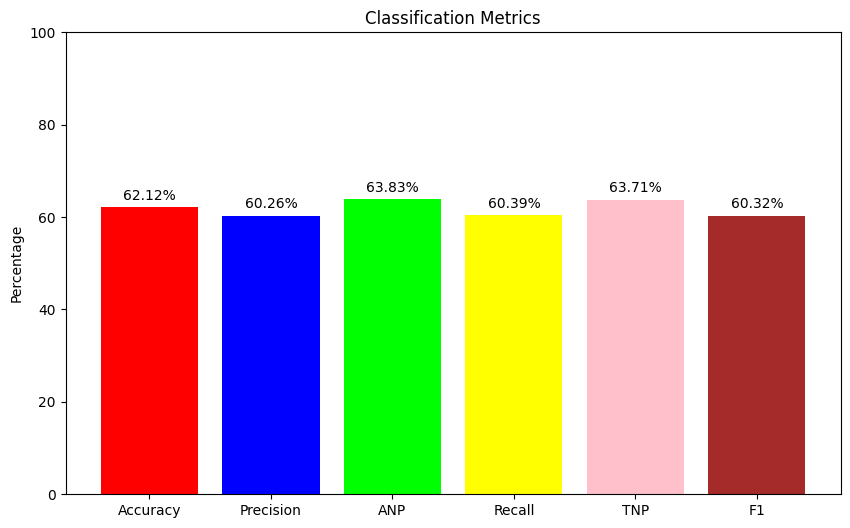

In [ ]:
lstm_cm = getConfusionMatrix(best_lstm_model, test_embeddings_np, test_labels_np)
printAndDrawAdditionalMetrics(lstm_cm)

In [ ]:
def build_bilstm_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                 return_sequences=False),
                            input_shape=(train_embeddings_np.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
# bilstm_tuner = MyTuner(
#     build_bilstm_model,
#     objective='val_accuracy',
#     max_epochs=12,
#     factor=3,
#     directory='my_dir_bilstm',
#     project_name='hyperparameter_tuning'
# )

# bilstm_tuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_bilstm_model = bilstm_tuner.get_best_models(num_models=1)[0]


# print(best_bilstm_model.summary())
# best_hps = bilstm_tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"Optimal number of units in the first dense layer: {best_hps.get('units')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
# print(f"Optimal batch size: {best_hps.get('batch_size')}")

In [ ]:
# bilstm_best_model = Sequential([
#     Bidirectional(LSTM(96, return_sequences=False),input_shape=(train_embeddings_np.shape[1], 1)),
#     Dropout(0.1),
#     Dense(1, activation='sigmoid')
# ])


# bilstm_best_model.compile(optimizer=Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


# print(bilstm_best_model.summary())

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_bilstm_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# history = bilstm_best_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np),
#                     callbacks=[checkpoint])

In [ ]:
best_bilstm_model = load_model('/content/drive/MyDrive/best_bilstm_model.h5')
best_bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 192)               75264     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 75457 (294.75 KB)
Trainable params: 75457 (294.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


179/179 [==============================] - 48s 260ms/step
Confusion Matrix:
[[2105  890]
 [1029 1700]]
Accuracy: 0.66
Precision: 0.66
Recall: 0.62
F1 Score: 0.64
Actual negatives predicted as percentage of predicted negatives: 67.17%
True Negatives as percentage of actual false labels: 70.28%


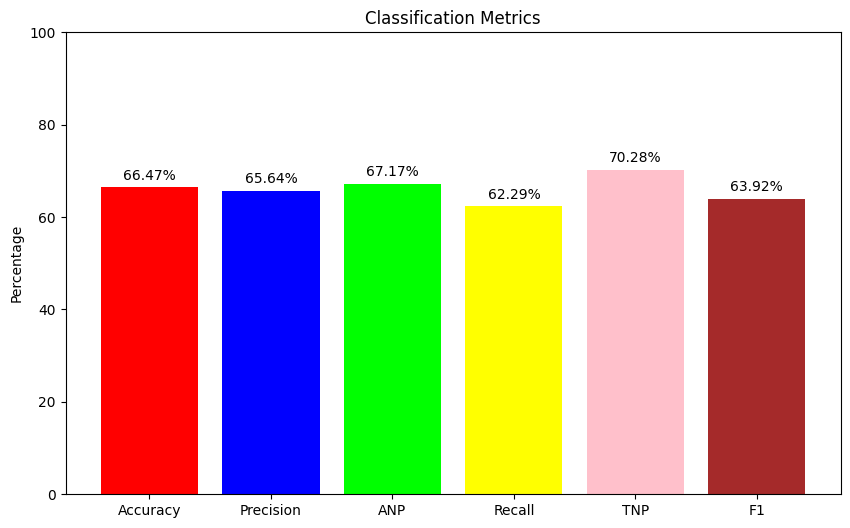

In [ ]:
bilstm_cm = getConfusionMatrix(best_bilstm_model, test_embeddings_np, test_labels_np)
printAndDrawAdditionalMetrics(bilstm_cm)

In [ ]:
def build_cnn_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
                     activation='relu',
                     input_shape=(train_embeddings_np.shape[1], 1)))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.4, step=0.1)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# cnn_tuner = MyTuner(
#     build_cnn_model,
#     objective='val_accuracy',
#     max_epochs=12,
#     factor=3,
#     directory='my_dir_cnn',
#     project_name='hyperparameter_tuning'
# )

# cnn_tuner.search(train_embeddings_np, train_labels_np,
#              epochs=12,
#              validation_data=(val_embeddings_np, val_labels_np))


# best_cnn_model = cnn_tuner.get_best_models(num_models=1)[0]


# print(best_cnn_model.summary())
# best_hps = cnn_tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"Optimal number of filters in the CNN layer: {best_hps.get('filters')}")
# print(f"Optimal kernel sie in the CNN layer: {best_hps.get('kernel_size')}")
# print(f"Optimal dropout rate: {best_hps.get('dropout')}")
# print(f"Optimal learning rate: {best_hps.get('learning_rate')}")
# print(f"Optimal batch size: {best_hps.get('batch_size')}")

In [ ]:
# cnn_best_model = Sequential([
#     Conv1D(filters=64,
#                      kernel_size=4,
#                      activation='relu',
#                      input_shape=(train_embeddings_np.shape[1], 1)),
#     Dropout(0.2),
#     Flatten(),
#     Dense(1, activation='sigmoid')
# ])


# cnn_best_model.compile(optimizer=Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


# print(cnn_best_model.summary())

# checkpoint = ModelCheckpoint('/content/drive/MyDrive/best_cnn_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

# history = cnn_best_model.fit(train_embeddings_np, train_labels_np,
#                     epochs=12,
#                     batch_size=32,
#                     validation_data=(val_embeddings_np, val_labels_np),
#                     callbacks=[checkpoint])

In [ ]:
best_cnn_model = load_model('/content/drive/MyDrive/best_cnn_model.h5')
best_cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 765, 64)           320       
                                                                 
 dropout_1 (Dropout)         (None, 765, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 48960)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 48961     
                                                                 
Total params: 49281 (192.50 KB)
Trainable params: 49281 (192.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


179/179 [==============================] - 1s 7ms/step
Confusion Matrix:
[[2420  575]
 [ 597 2132]]
Accuracy: 0.80
Precision: 0.79
Recall: 0.78
F1 Score: 0.78
Actual negatives predicted as percentage of predicted negatives: 80.21%
True Negatives as percentage of actual false labels: 80.80%


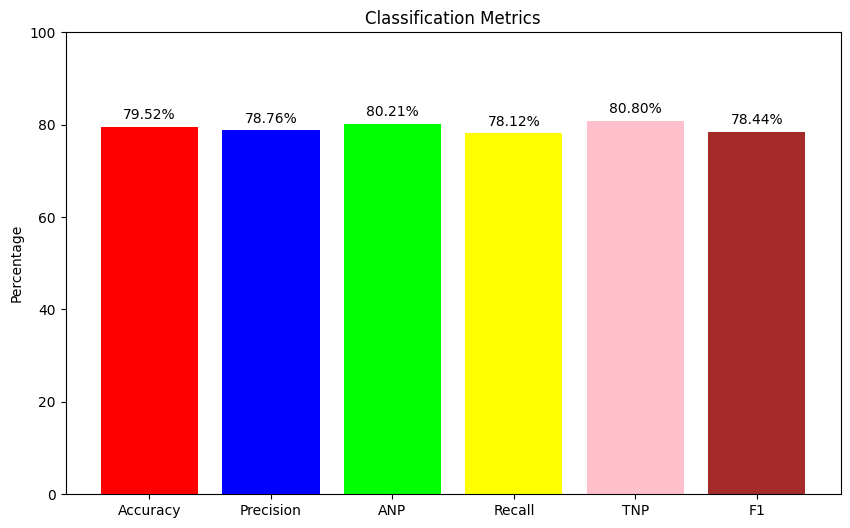

In [ ]:
cnn_cm = getConfusionMatrix(best_cnn_model, test_embeddings_np, test_labels_np)
printAndDrawAdditionalMetrics(cnn_cm)

In [ ]:
def GetMetricsFromConfusionMatrix(cm):
    TN, FP, FN, TP = cm.ravel()
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Actual positive predicted as percentage of predicted positives
    actual_pos_percent  = (TP / (FP + TP)) * 100
    # Actual negatives predicted as percentage of predicted negatives
    actual_neg_percent    = (TN / (TN + FN)) * 100
    # True Positives as percentage of actual true labels
    tp_percent  = (TP / (TP + FN)) * 100
    # True Negatives as percentage of actual false labels
    tn_percent  = (TN / (TN + FP)) * 100

    return accuracy, precision, recall, f1, tp_percent, tn_percent, actual_pos_percent, actual_neg_percent

In [ ]:
def plot_metrics(metrics, model_names, metric_name):
    plt.figure(figsize=(10, 6))
    plt.bar(model_names, metrics, color=['green', 'blue', 'orange', 'red', 'purple'])
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'Comparison of {metric_name} across Models')
    plt.show()

In [ ]:
model_names = ['Dense', 'GRU', 'LSTM', 'BiLSTM', 'CNN']

In [ ]:
metrics_dense = GetMetricsFromConfusionMatrix(dense_cm)
metrics_gru = GetMetricsFromConfusionMatrix(gru_cm)
metrics_lstm = GetMetricsFromConfusionMatrix(lstm_cm)
metrics_bilstm = GetMetricsFromConfusionMatrix(bilstm_cm)
metrics_cnn = GetMetricsFromConfusionMatrix(cnn_cm)

In [ ]:
accuracies = [metrics_dense[0], metrics_gru[0], metrics_lstm[0], metrics_bilstm[0], metrics_cnn[0]]
precisions = [metrics_dense[1], metrics_gru[1], metrics_lstm[1], metrics_bilstm[1], metrics_cnn[1]]
recalls = [metrics_dense[2], metrics_gru[2], metrics_lstm[2], metrics_bilstm[2], metrics_cnn[2]]
f1_scores = [metrics_dense[3], metrics_gru[3], metrics_lstm[3], metrics_bilstm[3], metrics_cnn[3]]
tp_percents = [metrics_dense[4], metrics_gru[4], metrics_lstm[4], metrics_bilstm[4], metrics_cnn[4]]
tn_percents = [metrics_dense[5], metrics_gru[5], metrics_lstm[5], metrics_bilstm[5], metrics_cnn[5]]
actual_pos_percents = [metrics_dense[6], metrics_gru[6], metrics_lstm[6], metrics_bilstm[6], metrics_cnn[6]]
actual_neg_percents = [metrics_dense[7], metrics_gru[7], metrics_lstm[7], metrics_bilstm[7], metrics_cnn[7]]

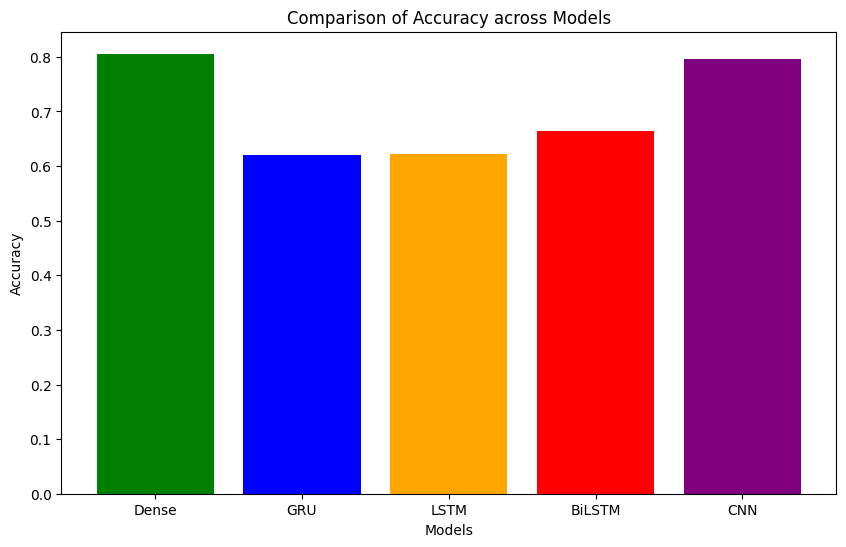

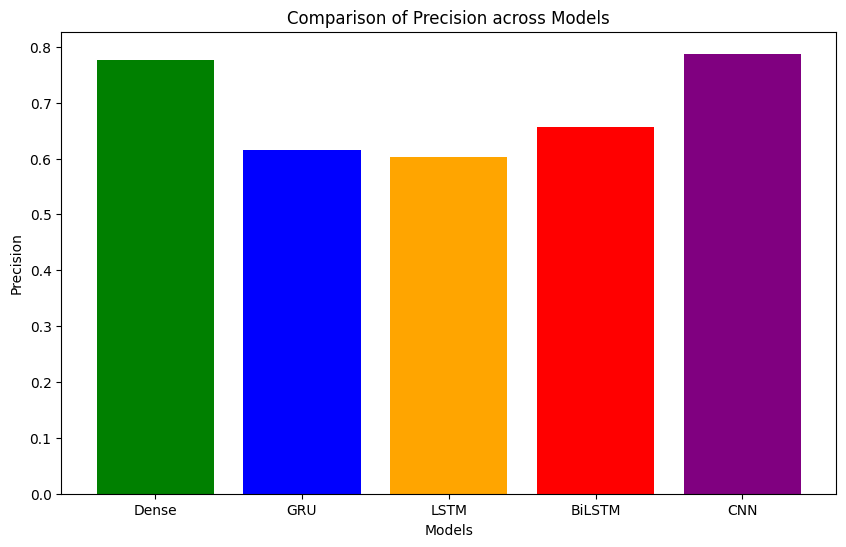

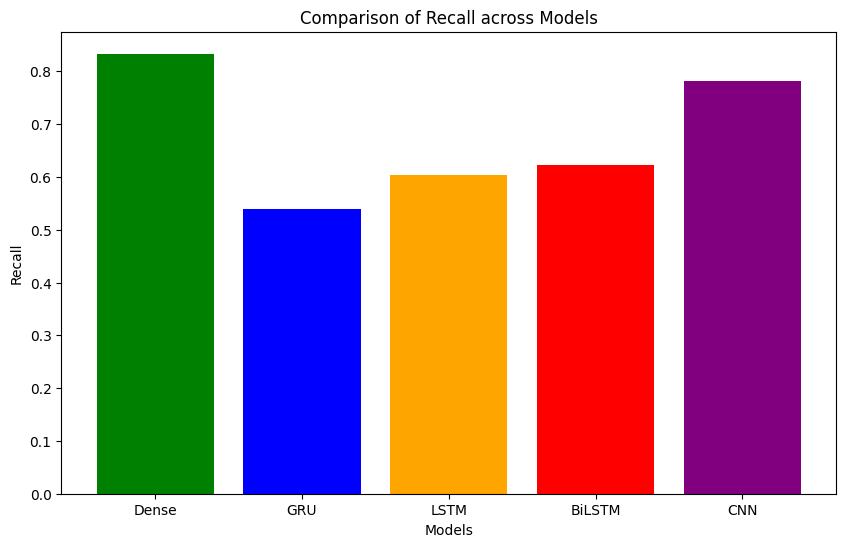

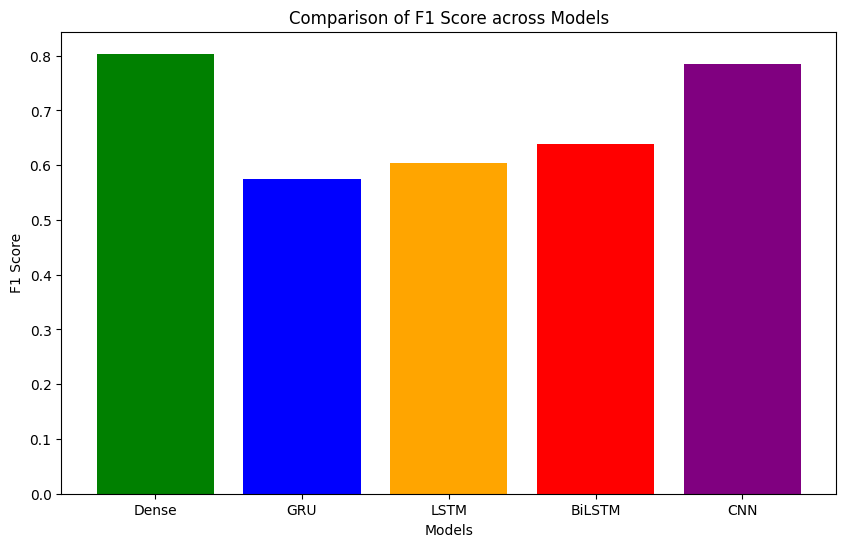

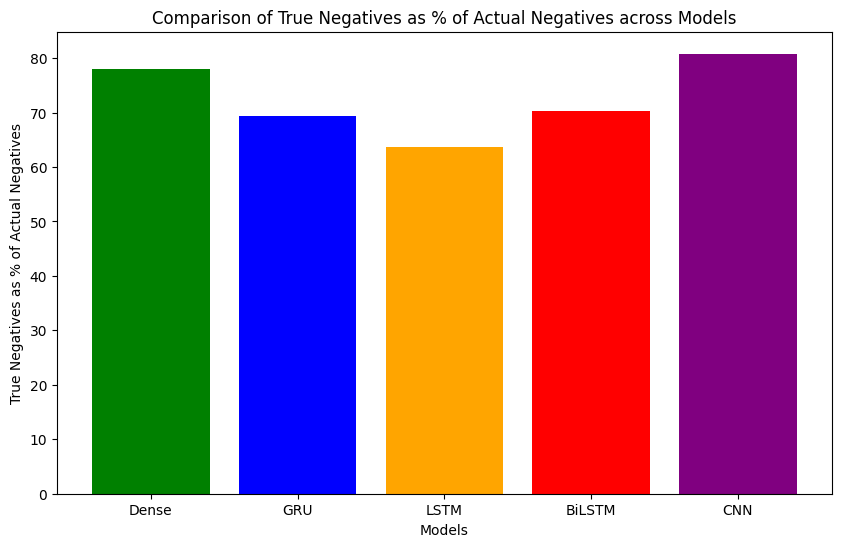

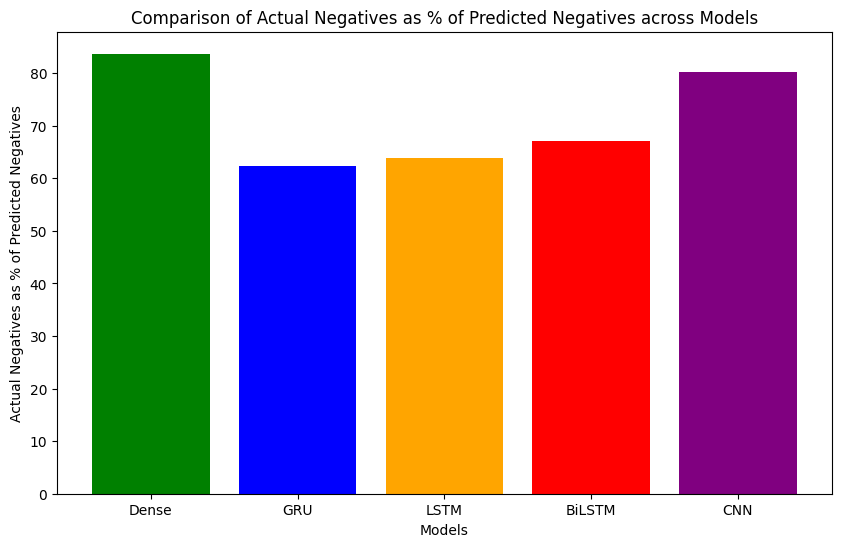

In [ ]:
plot_metrics(accuracies, model_names, 'Accuracy')
plot_metrics(precisions, model_names, 'Precision')
plot_metrics(recalls, model_names, 'Recall')
plot_metrics(f1_scores, model_names, 'F1 Score')
#plot_metrics(tp_percents, model_names, 'True Positives as % of Actual Positives')
plot_metrics(tn_percents, model_names, 'True Negatives as % of Actual Negatives')
#plot_metrics(actual_pos_percents, model_names, 'Actual Positives as % of Predicted Positives')
plot_metrics(actual_neg_percents, model_names, 'Actual Negatives as % of Predicted Negatives')

In [ ]:
# !pip install shap

In [ ]:
# import shap
# from sklearn.cluster import KMeans

In [ ]:
# num_samples = 100
# kmeans = KMeans(n_clusters=num_samples, random_state=42).fit(train_embeddings_np)
# background = kmeans.cluster_centers_

In [ ]:
# np.save('/content/drive/MyDrive/background_samples.npy', background)

In [ ]:
# background = np.load('/content/drive/MyDrive/background_samples.npy')

In [ ]:
# explainer = shap.KernelExplainer(best_dense_model.predict, background)

In [ ]:
# Define a function to calculate SHAP values in smaller chunks
# def calculate_shap_values_in_chunks(explainer, data, chunk_size=100):
#     shap_values = []
#     num_samples = data.shape[0]
#     for i in range(0, num_samples, chunk_size):
#         data_chunk = data[i:i + chunk_size]
#         shap_values_chunk = explainer.shap_values(data_chunk)
#         shap_values.append(shap_values_chunk)
#     return np.concatenate(shap_values, axis=1)

In [ ]:
# chunk_size = 10
# shap_values = calculate_shap_values_in_chunks(explainer, val_embeddings_np, chunk_size=chunk_size)

In [ ]:
def count_unique_correct_predictions(models, model_names, test_embeddings, test_labels):
    # Dictionary to store the count of samples each model predicted correctly
    unique_correct_counts = {name: 0 for name in model_names}
    unique_wrong_counts = {name: 0 for name in model_names}

    # List to store predictions of each model
    predictions = [model.predict(test_embeddings) for model in models]

    # Convert predictions to binary labels (0 or 1)
    predictions = [np.round(pred) for pred in predictions]

    # Iterate through each sample in the test set
    for i in range(len(test_labels)):
        correct_predictions = []
        wrong_predictions = []
        for j in range(len(models)):
            if predictions[j][i] == test_labels[i]:
                correct_predictions.append(model_names[j])
            else:
                wrong_predictions.append(model_names[j])

        # If only one model predicted correctly, increase its count
        if len(correct_predictions) == 1:
            unique_correct_counts[correct_predictions[0]] += 1
        if len(wrong_predictions) == 1:
            unique_wrong_counts[wrong_predictions[0]] += 1

    return unique_correct_counts, unique_wrong_counts

In [ ]:
models = [best_dense_model, best_gru_model, best_lstm_model, best_bilstm_model, best_cnn_model]
model_names = ['Dense', 'GRU', 'LSTM', 'BiLSTM', 'CNN']

unique_correct_counts, unique_wrong_counts = count_unique_correct_predictions(models, model_names, test_embeddings_np, test_labels_np)



179/179 [==============================] - 1s 7ms/step


In [ ]:
print(f'unique_correct_counts: {unique_correct_counts}')
print(f'unique_wrong_counts: {unique_wrong_counts}')

unique_correct_counts: {'Dense': 148, 'GRU': 50, 'LSTM': 39, 'BiLSTM': 63, 'CNN': 64}
unique_wrong_counts: {'Dense': 138, 'GRU': 285, 'LSTM': 232, 'BiLSTM': 292, 'CNN': 87}


In [ ]:
correct_counts = list(unique_correct_counts.values())
wrong_counts = list(unique_wrong_counts.values())

<ipython-input-67-de590895c1c6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=correct_counts, palette=colors)


Text(0, 0.5, 'Unique Correct Counts')

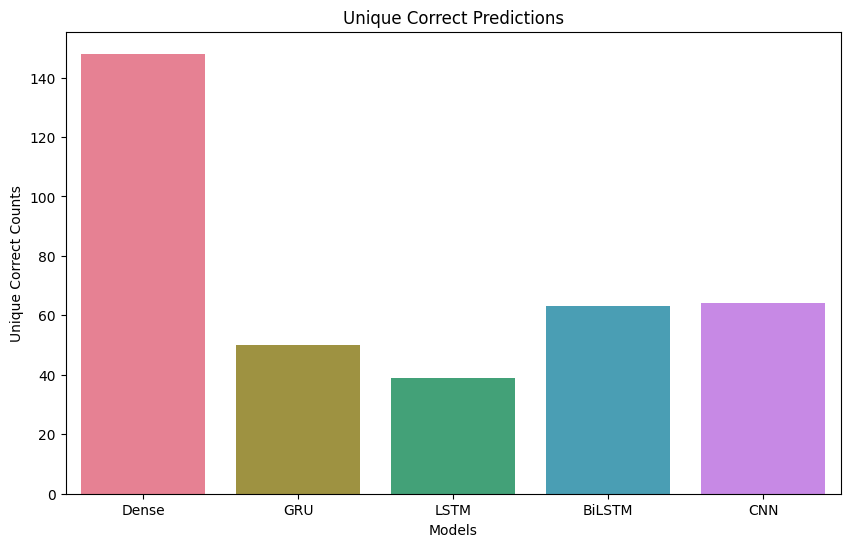

In [ ]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(model_names))
sns.barplot(x=model_names, y=correct_counts, palette=colors)
plt.title('Unique Correct Predictions')
plt.xlabel('Models')
plt.ylabel('Unique Correct Counts')

<ipython-input-68-dde5144397d3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=wrong_counts, palette=colors)


Text(0, 0.5, 'Unique Wrong Counts')

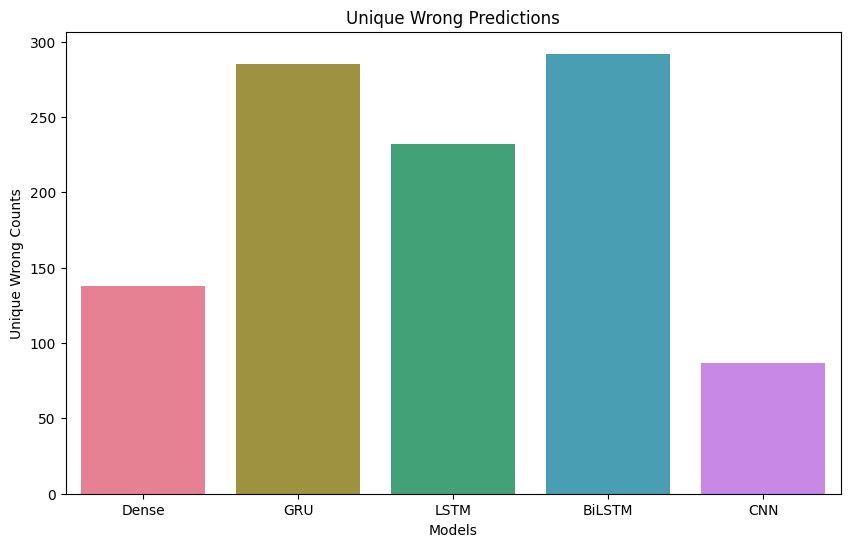

In [ ]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(model_names))
sns.barplot(x=model_names, y=wrong_counts, palette=colors)
plt.title('Unique Wrong Predictions')
plt.xlabel('Models')
plt.ylabel('Unique Wrong Counts')


In [ ]:
probs = best_dense_model.predict(test_embeddings_np)

179/179 [==============================] - 0s 2ms/step


In [ ]:
fprobs = probs.flatten()
fprobs.ndim

1

In [ ]:
def plot_roc_auc_curves(models, model_names, test_embeddings, test_labels):
    plt.figure(figsize=(10, 8))

    for model, name in zip(models, model_names):
        # Predict probabilities
        y_probs = model.predict(test_embeddings)


        #y_probs = y_probs.flatten()

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(test_labels, y_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

179/179 [==============================] - 2s 10ms/step


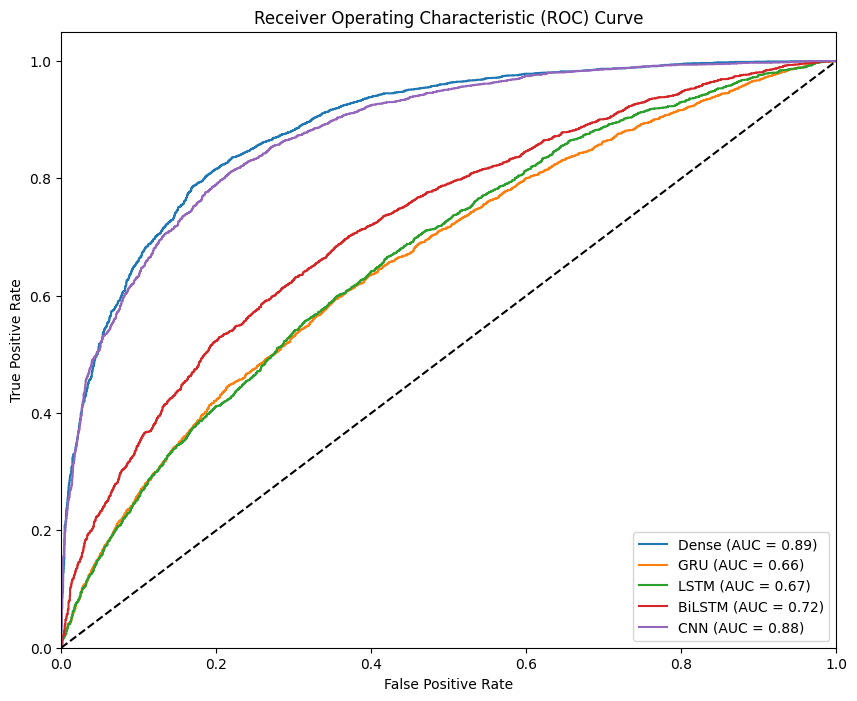

In [ ]:
plot_roc_auc_curves(models, model_names, test_embeddings_np, test_labels_np)

In [ ]:
def plot_precision_recall_curves(models, model_names, test_embeddings, test_labels):
    # Store predictions and precision-recall data
    predictions = []
    precision_recall_data = []

    # Predict probabilities and calculate precision-recall data for each model
    for model in models:
        y_probs = model.predict(test_embeddings)
        predictions.append(y_probs)
        precision, recall, _ = precision_recall_curve(test_labels, y_probs)
        avg_precision = average_precision_score(test_labels, y_probs)
        precision_recall_data.append((precision, recall, avg_precision))

    # Plot all models together
    plt.figure(figsize=(10, 8))
    for (precision, recall, avg_precision), name in zip(precision_recall_data, model_names):
        plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for All Models')
    plt.legend(loc='lower left')
    plt.show()

    # Plot each model separately
    for (precision, recall, avg_precision), name in zip(precision_recall_data, model_names):
        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.2f})')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve for model {name}')
        plt.legend(loc='lower left')
        plt.show()


179/179 [==============================] - 2s 9ms/step


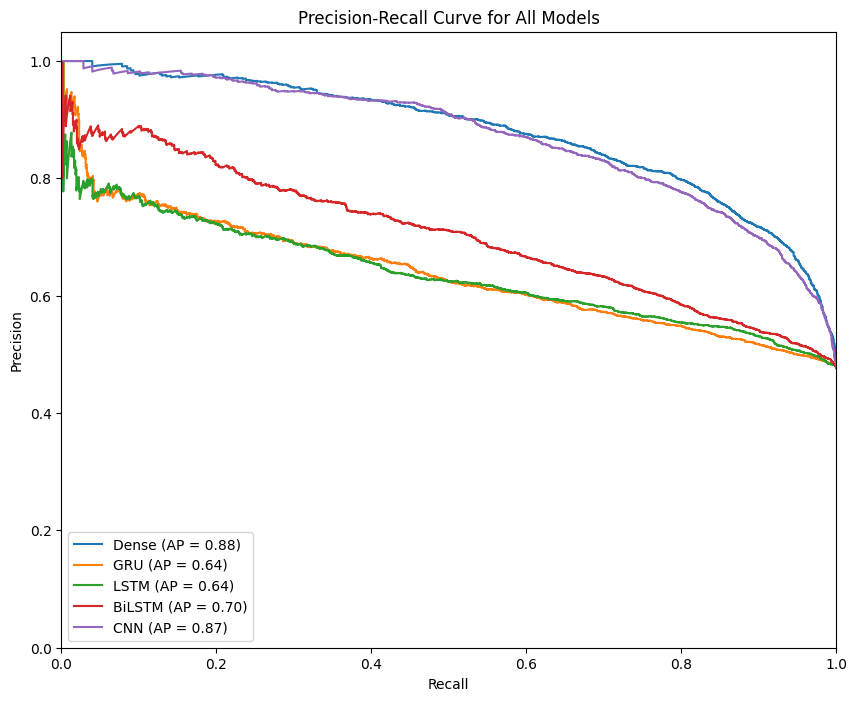

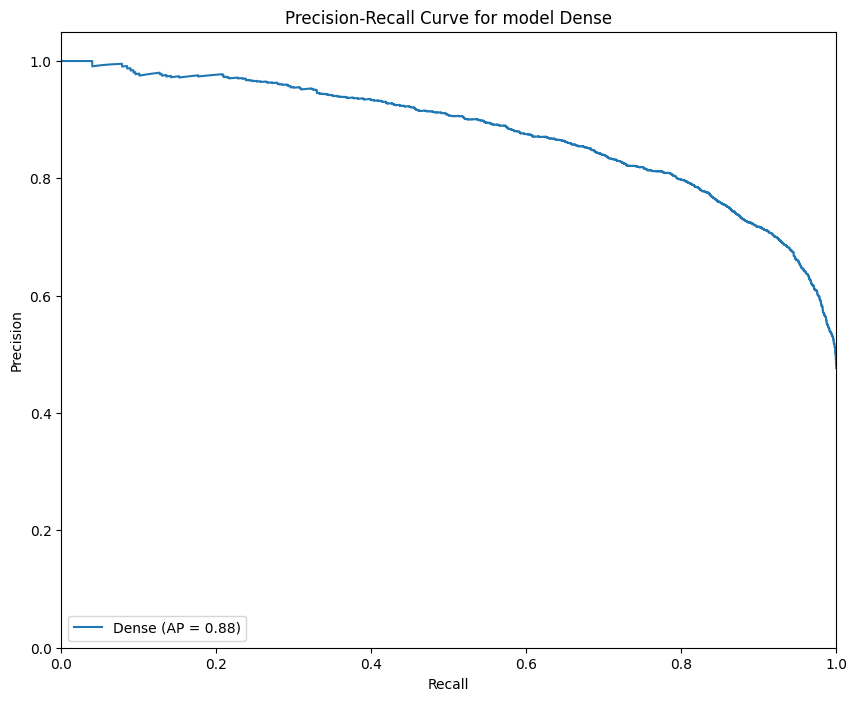

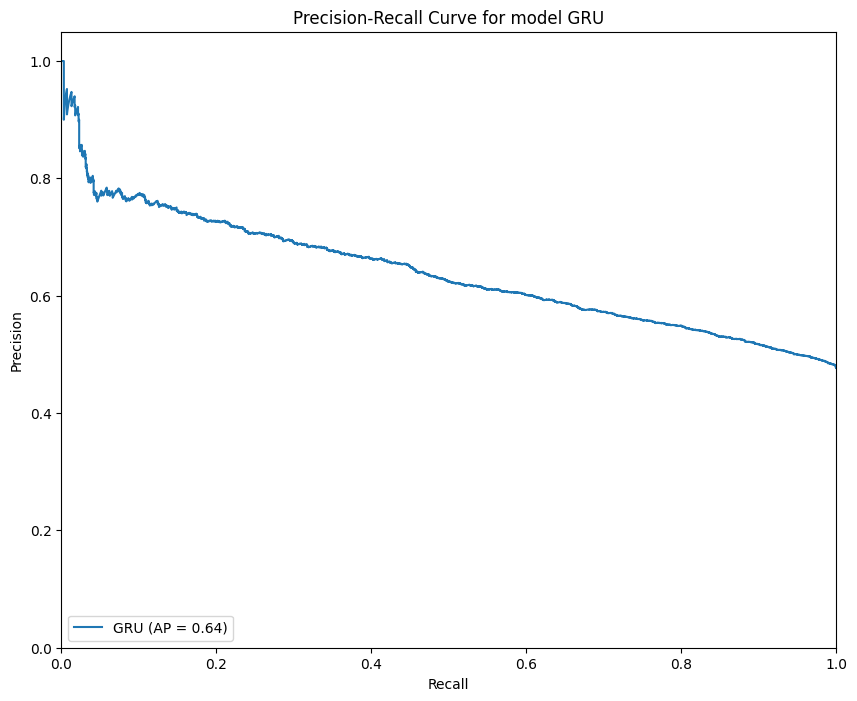

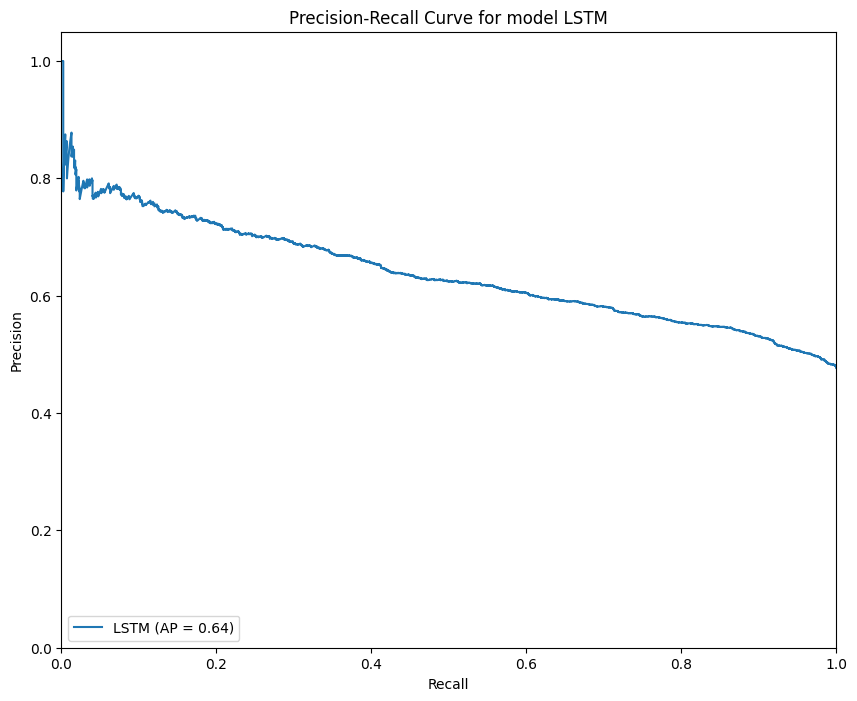

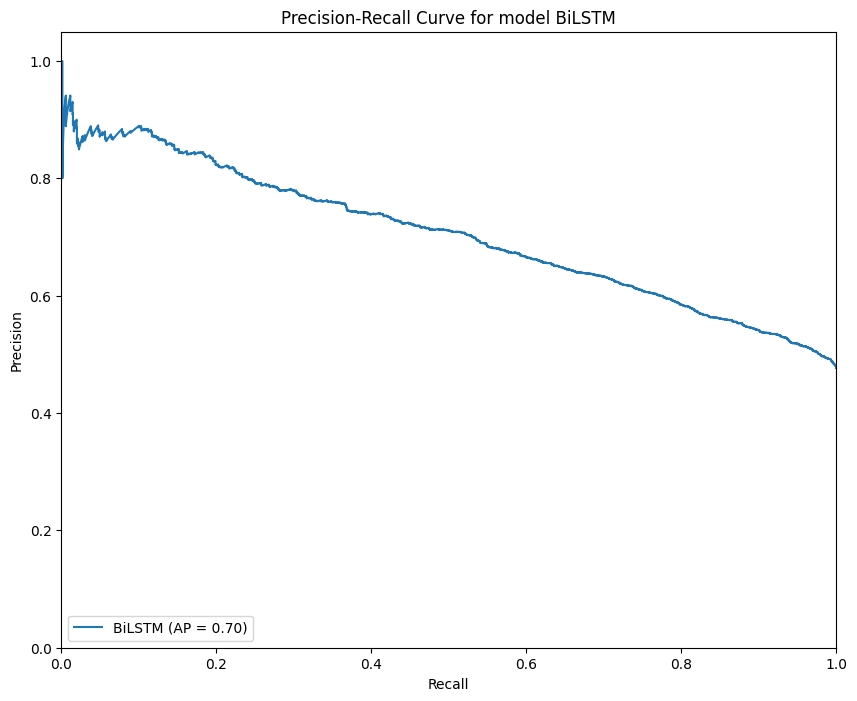

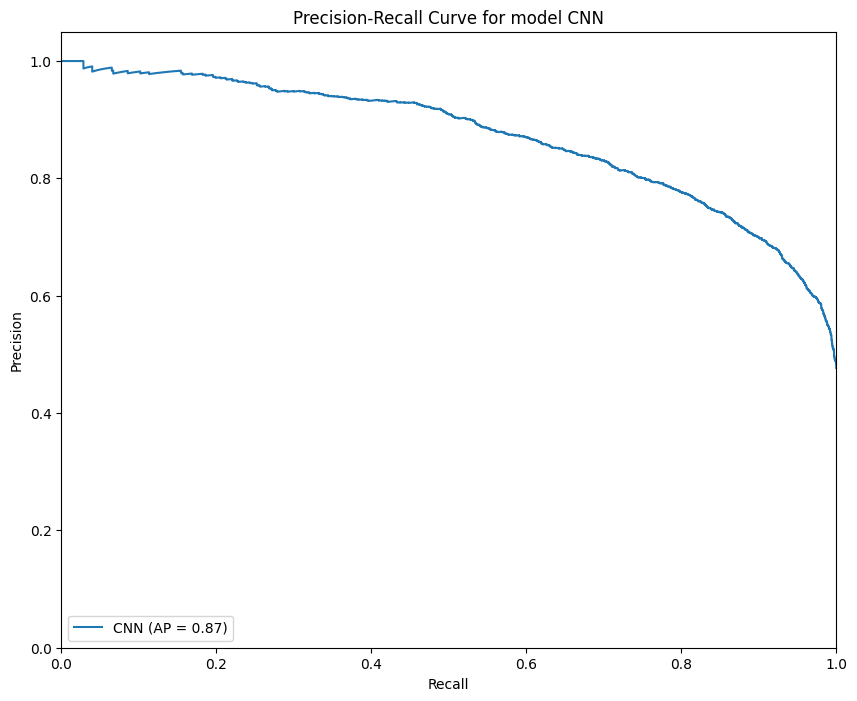

In [ ]:
plot_precision_recall_curves(models, model_names, test_embeddings_np, test_labels_np)

The process followed ensures that the embeddings are created in the same order as the headlines in test_df. Here’s a summary of how that order is preserved:

Tokenization: By using test_df['headline'].tolist(), you convert the headlines to a list that maintains the original order.

Batch Processing: In get_bert_embeddings, the input IDs and attention masks are processed in batches but remain in the same sequence.

Concatenation: When concatenating the embeddings, the order is preserved since you’re stacking the results from each batch sequentially.

In [ ]:
# Assuming you have your predictions for each model
dense_predictions = best_dense_model.predict(test_embeddings_np)  # Replace with your model's prediction method
gru_predictions = best_gru_model.predict(test_embeddings_np)
lstm_predictions = best_lstm_model.predict(test_embeddings_np)
bilstm_predictions = best_bilstm_model.predict(test_embeddings_np)
cnn_predictions = best_cnn_model.predict(test_embeddings_np)

# Convert predictions to binary if necessary (e.g., if outputs are probabilities)
dense_predictions_binary = (dense_predictions > 0.5).astype(int)
gru_predictions_binary = (gru_predictions > 0.5).astype(int)
lstm_predictions_binary = (lstm_predictions > 0.5).astype(int)
bilstm_predictions_binary = (bilstm_predictions > 0.5).astype(int)
cnn_predictions_binary = (cnn_predictions > 0.5).astype(int)

179/179 [==============================] - 1s 6ms/step


In [ ]:
results_df = pd.DataFrame({
    'headline': test_df['headline'],
    'actual': test_df['is_sarcastic'],
    'dense_prob': dense_predictions.flatten(),
    'dense_pred': dense_predictions_binary.flatten(),
    'gru_prob': gru_predictions.flatten(),
    'gru_pred': gru_predictions_binary.flatten(),
    'lstm_prob': lstm_predictions.flatten(),
    'lstm_pred': lstm_predictions_binary.flatten(),
    'bilstm_prob': bilstm_predictions.flatten(),
    'bilstm_pred': bilstm_predictions_binary.flatten(),
    'cnn_prob': cnn_predictions.flatten(),
    'cnn_pred': cnn_predictions_binary.flatten(),
})

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
def print_model_predictions(results_df, model_name):
    correct_predictions = results_df[results_df[f'{model_name}_pred'] == results_df['actual']]
    incorrect_predictions = results_df[results_df[f'{model_name}_pred'] != results_df['actual']]

    print(f"\nCorrectly Predicted Headlines by {model_name}:")
    print(correct_predictions[['headline', 'actual', f'{model_name}_prob', f'{model_name}_pred']].head(3))

    print(f"\nIncorrectly Predicted Headlines by {model_name}:")
    print(incorrect_predictions[['headline', 'actual', f'{model_name}_prob', f'{model_name}_pred']].head(3))

model_names = ['dense', 'gru', 'lstm', 'bilstm', 'cnn']
# Print predictions for each model
for model_name in model_names:
    print_model_predictions(results_df, model_name)


Correctly Predicted Headlines by dense:
                                                                                                   headline  \
27927                                                      states slow shut weak teacher education programs   
1660                                                              drone places fresh kill steps white house   
96     report majority instances people getting lives back track occur immediately visit buffalo wild wings   

       actual  dense_prob  dense_pred  
27927       0    0.235102           0  
1660        1    0.845161           1  
96          1    0.999799           1  

Incorrectly Predicted Headlines by dense:
                                                                headline  \
843                sean spicer finally calls quits 6 months humiliations   
22778  band targeted paris attacks makes emotional return finish concert   
23948                        track winnings reinvested blackjack futures   

      

In [ ]:
results_df.loc[843]['headline']

'sean spicer finally calls quits 6 months humiliations'